In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load Data

In [113]:
waste_data = pd.read_csv("synthetic_waste_data.csv")
waste_data

,date,arrival_time,company,truck_id,waste_type,quantity_tons,quality_score,moisture_content,contamination_level,heating_value_MJ_per_kg
0,2022-01-01,2022-01-01 06:27:00,RegionalWaste Management,Reg3,Municipal,11.486050,7.929559,37.493209,2.070441,7.263229
1,2022-01-01,2022-01-01 06:32:00,RegionalWaste Management,Reg1,Industrial,19.855091,6.868888,18.746604,3.131112,11.807504
2,2022-01-01,2022-01-01 09:58:00,GreenWaste Solutions,Gre2,Organic,3.835948,6.364174,74.986417,3.635826,2.539645
3,2022-01-01,2022-01-01 10:06:00,IndustrialProcess Ltd,Ind1,Industrial,41.565434,8.821311,18.746604,1.178689,12.570800
4,2022-01-01,2022-01-01 10:14:00,GreenWaste Solutions,Gre1,Municipal,4.895075,6.149050,37.493209,3.850950,6.849568
...,...,...,...,...,...,...,...,...,...,...
17313,2024-12-31,2024-12-31 11:40:00,BuildRight Construction,Bui1,Construction,11.027408,5.704726,20.470406,4.295274,5.970507
17314,2024-12-31,2024-12-31 13:17:00,MunicipalWaste Co,Mun3,Municipal,16.620243,7.470465,34.117343,2.529535,7.385865
17315,2024-12-31,2024-12-31 13:34:00,IndustrialProcess Ltd,Ind3,Industrial,20.554325,8.548314,17.058671,1.451686,12.633587
17316,2024-12-31,2024-12-31 14:45:00,CommercialServices Inc,Com1,Commercial,16.317348,7.322251,22.744895,2.677749,9.278920


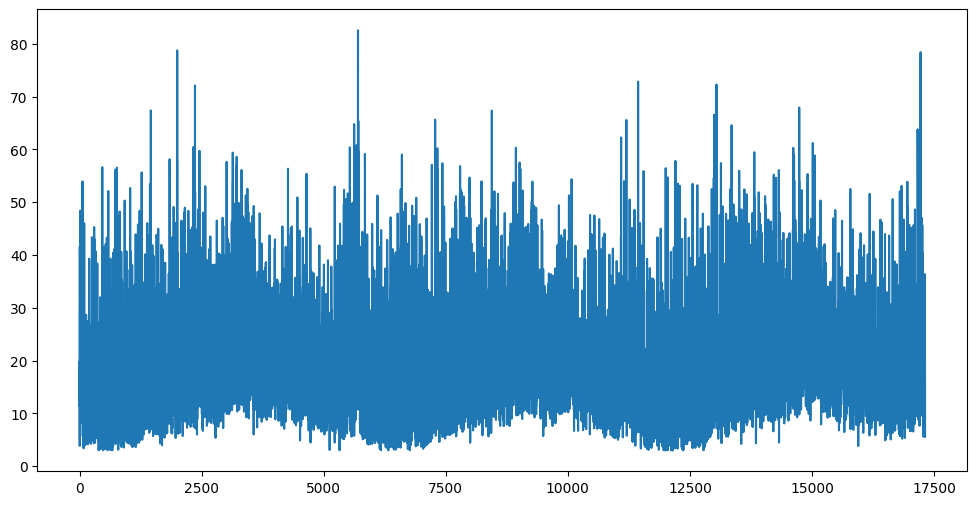

In [114]:
plt.figure(figsize=(12,6))
plt.plot(waste_data["quantity_tons"])
plt.show()

Data is very noise, probably because there are many arrivals per day -> Aggregate the arriving waste day-wise

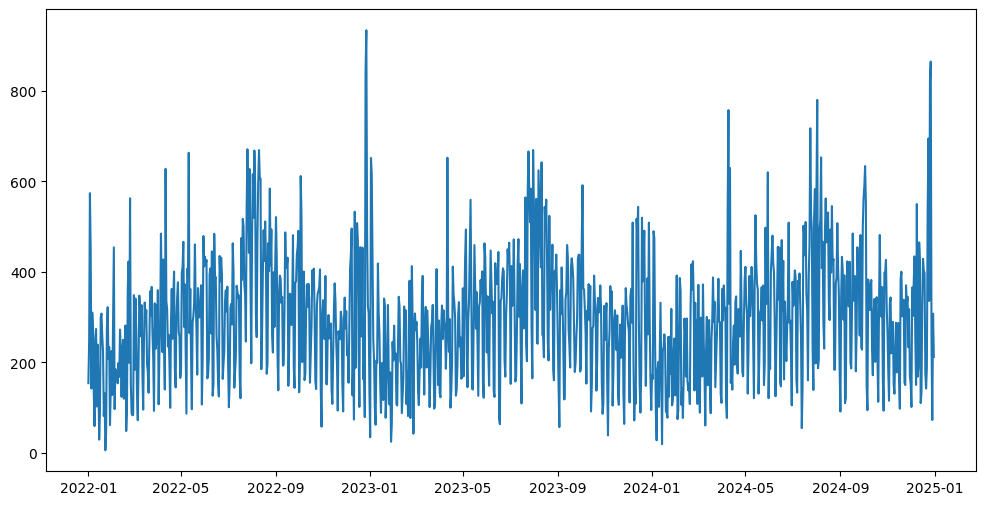

In [115]:
waste_data['date'] = pd.to_datetime(waste_data['date'])

aggregated_waste_data = waste_data.groupby(waste_data['date'].dt.date)['quantity_tons'].sum()

plt.figure(figsize=(12,6))
plt.plot(aggregated_waste_data)
plt.show()

There is a noticeable  yearly pattern in the data. Still, it is a rather noisy time series -> Moving average for better inspection.

In [116]:
print(type(aggregated_waste_data))
agg_waste_df = pd.DataFrame(aggregated_waste_data)
print(type(agg_waste_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


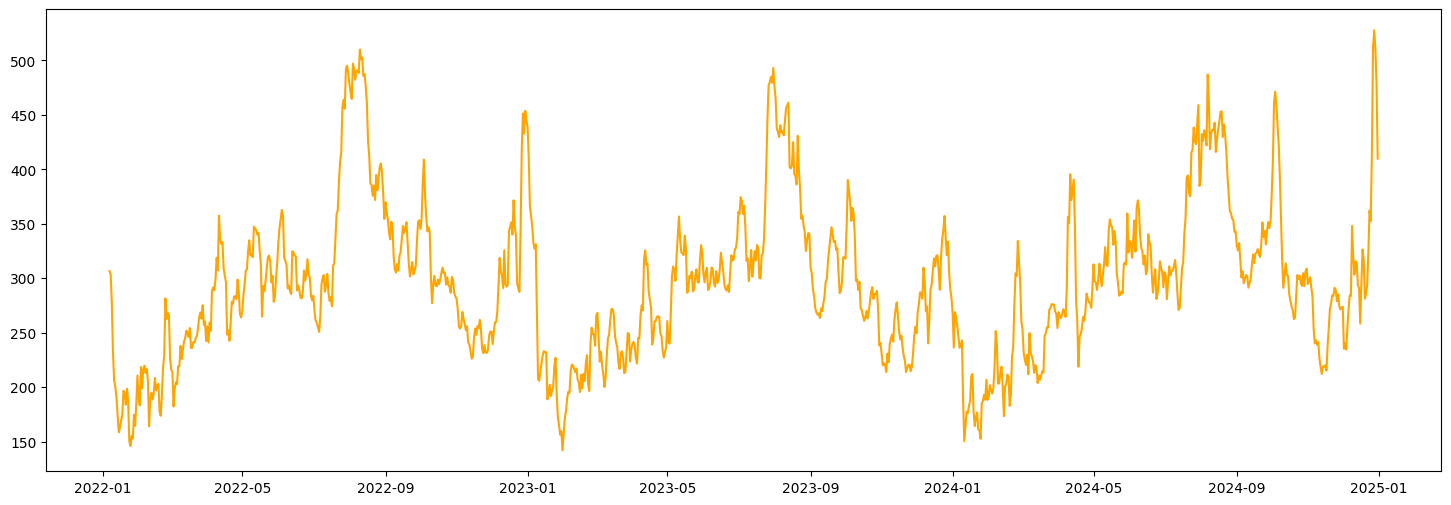

In [117]:
window_size = 7  
agg_waste_df['smoothed'] = agg_waste_df['quantity_tons'].rolling(window=window_size).mean()

plt.figure(figsize=(18,6))
plt.plot(agg_waste_df['smoothed'], color = "orange")
plt.show()

Some dates are particularly eye catching:

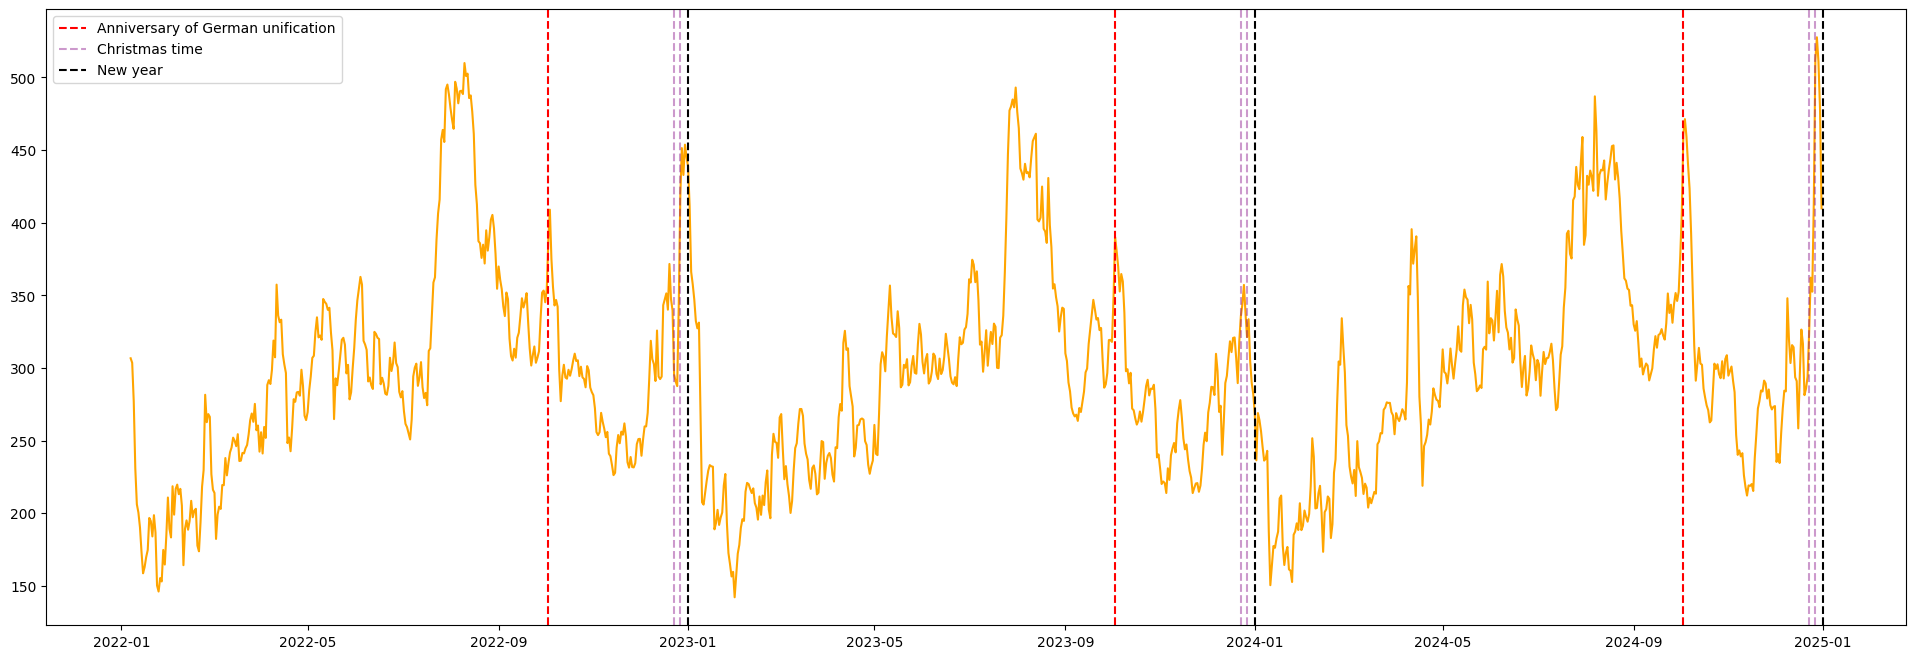

In [ ]:
holidays = {
    'Christmas time': {
        'dates': ['2022-12-23', '2022-12-27', '2023-12-23', '2023-12-27', '2024-12-23', '2024-12-27'],
        'color': 'purple',
        'linestyle': '--',
        'alpha': 0.4
    },
    'New year': {
        'dates': ['2023-01-01', '2024-01-01', '2025-01-01'],
        'color': 'black',
        'linestyle': '--',
        'alpha': 1.0
    }
}

plt.figure(figsize=(24,8))
plt.plot(agg_waste_df['smoothed'], color = "orange")

for holiday_name, holiday_info in holidays.items():
    # Plot first date with label
    plt.axvline(
        x= pd.to_datetime(holiday_info['dates'][0]), 
        color=holiday_info['color'], 
        linestyle=holiday_info['linestyle'], 
        label=holiday_name,
        alpha=holiday_info['alpha']
    )
    
    # Plot remaining dates without label
    for date in holiday_info['dates'][1:]:
        plt.axvline(
            x=pd.to_datetime(date), 
            color=holiday_info['color'], 
            linestyle=holiday_info['linestyle'],
            alpha=holiday_info['alpha']
        )
plt.legend()
plt.show()

Implication: Special holidays should be considered in the forecasting model, e.g. via a binary variable.
Also there are peaks towards the end of summer, so considering the season might be important as well

Is there a difference between weekdays and weekends? 

In [119]:
agg_waste_df = agg_waste_df.reset_index()
agg_waste_df["date"] = pd.to_datetime(agg_waste_df["date"])

# Create a new column that identifies weekday vs weekend
agg_waste_df['is_weekend'] = agg_waste_df['date'].dt.dayofweek >= 5  # 5=Saturday, 6=Sunday

# Create a day type column 
agg_waste_df['day_type'] = agg_waste_df['is_weekend'].apply(lambda x: 'Weekend' if x else 'Weekday')


weekday_vs_weekend = agg_waste_df.groupby('day_type')['quantity_tons'].sum().reset_index()
total_tons = weekday_vs_weekend['quantity_tons'].sum()
weekday_vs_weekend['percentage'] = (weekday_vs_weekend['quantity_tons'] / total_tons * 100).round(2)


print(weekday_vs_weekend)

  day_type  quantity_tons  percentage
0  Weekday  274704.392868       84.68
1  Weekend   49693.266869       15.32


Implication: Type of day should be considered in the forecasting model, e.g. via a binary variable

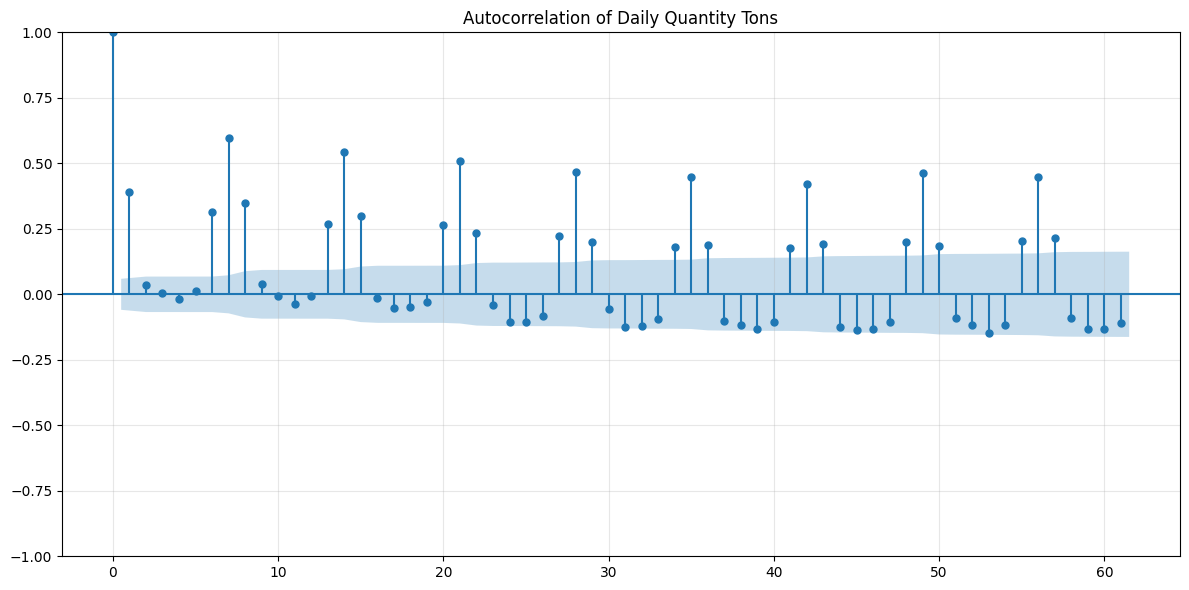

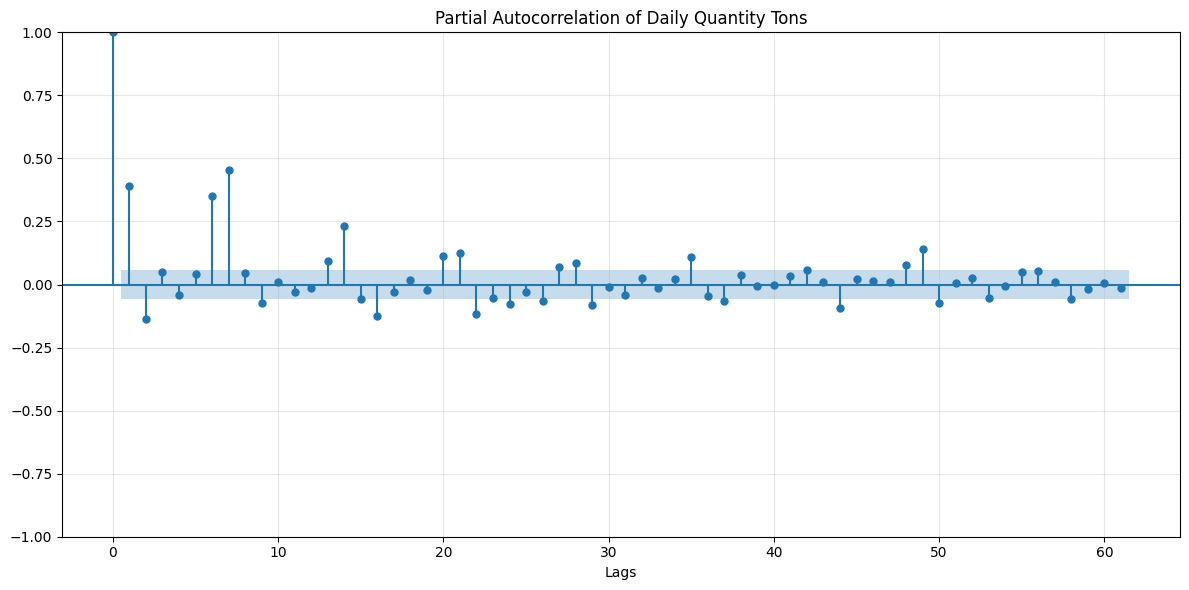

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lag = 61

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(agg_waste_df["quantity_tons"], ax=ax, lags=max_lag)  
plt.title('Autocorrelation of Daily Quantity Tons')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(agg_waste_df["quantity_tons"], ax=ax, lags=max_lag)
plt.title('Partial Autocorrelation of Daily Quantity Tons')
plt.xlabel("Lags")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Autocorrelation plot indicates weekly seasonality.

Probably the reason why the partial autocorrelation of the 7th lag is higher than the 1st lag -> 7th lag is important for forecasting.